<a href="https://colab.research.google.com/github/SudeepSarkar/Undergraduate-Computer-Vision/blob/main/CAP_4410_Lecture_6_Image_Pyramid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021, Sudeep Sarkar, University of South Florida, Tampa

# Image Pyramids

* Section 3.5 (second edition)

* Good filters for changing image resolution, i.e., up-sampling (interpolation) and down-sampling (decimation).

* An image pyramid is a representation built for one image. Starting from the original resolution, we progressively down-sample it until we reach some desired stopping size.

* Complete hierarchy of differently sized images enables various applications: reduce and expand image size, blend images, find objects in an image, fast matching of objects.


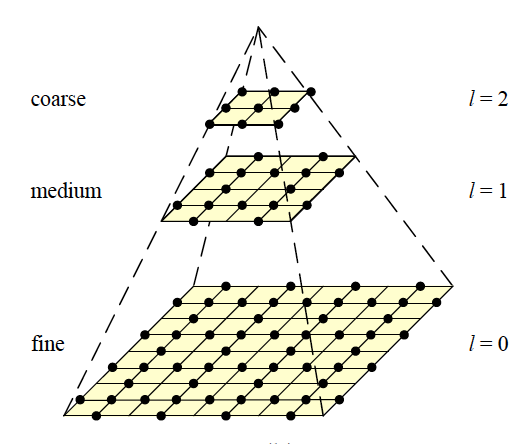

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from skimage.color import rgb2gray

from scipy import ndimage as scimage
# SciPy (pronounced “Sigh Pie”) is a Python-based ecosystem of open-source software for mathematics, science, and engineering.
# https://www.scipy.org/

np.set_printoptions(precision=2)

In [32]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 apple.jpg				     mountain_peak_1.png
'Armes 1.png'				     mountain_peak_2.png
'Armes 2.png'				     parking_lot_meva_1.png
 declaration_of_independence_stone_630.jpg   parking_lot_meva_2.png
 Fig3_3a.jpg				     parking_lot_meva_3.png
 Fig3_4a.jpg				    'Superbowl 2021_1.png'
 Fig3_4c.jpg				    'Superbowl 2021_2.png'
 house_1.png				    'Superbowl 2021_3.png'
 house_2.png				     Total-Text-Dataset
 lizard.jpg				     Total-Text-Dataset.zip


# Useful python code snippets

In [ ]:
# Example code to demonstrate an ability of python that we will use.
# Python snipet to generate (x, y) location/index pairs for all of the 12 pixels in an 4 by 3 image.

x, y = np.meshgrid(np.arange(3), np.arange(4))

print('x index is generated using np.arange(3)=', np.arange(3), '\ny index is generated using np.arange(4)=', np.arange(4), '\ny=', y.reshape(-1), '\nx=', x.reshape(-1))

x index is generated using np.arange(3)= [0 1 2] 
y index is generated using np.arange(4)= [0 1 2 3] 
y= [0 0 0 1 1 1 2 2 2 3 3 3] 
x= [0 1 2 0 1 2 0 1 2 0 1 2]


In [ ]:
# Indexing -- negative indexing

# for arrays
a = np.array([1, 3, 4, 5])
print(a[-1], a[-2], a[-3], a[-4])
print(a[0], a[1], a[2], a[3])

# for lists
b = [1, 3, 4]
b.append(5)
print('\n', a[-1], a[-2], a[-3], a[-4])
print(a[0], a[1], a[2], a[3])

5 4 3 1
1 3 4 5

 5 4 3 1
1 3 4 5


In [33]:
def padded_add (a, b) :
    # Returns the addition of arrays a and b, which can be of different sizes. 
    # We pad a and b with additional zero-valued rows and columns to make them of the same size.
    # The output size is the maximum of two arrays.
    # You can use this to also substract to arrays of different sizes -- just pass it -b instead of b

    h1, w1 = a.shape
    h2, w2 = b.shape
    h3 = np.max([h1, h2])
    w3 = np.max([w1, w2])

    a = np.pad(a, ((0, h3-h1), (0, w3-w1)))
    b = np.pad(b, ((0, h3-h2), (0, w3-w2)))
    #print('a=\n', a, '\nb=\n', b)
    return(a+b)

A = np.array([[1, 1], [2, 2], [3, 3]])
B = np.array([[1, 1, 2], [2, 2, 2]])

print('A=\n', A, '\nB=\n', B, '\nA+B=\n', padded_add(A, B), '\nA-B=\n', padded_add(A, -B))

A=
 [[1 1]
 [2 2]
 [3 3]] 
B=
 [[1 1 2]
 [2 2 2]] 
A+B=
 [[2 2 2]
 [4 4 2]
 [3 3 0]] 
A-B=
 [[ 0  0 -2]
 [ 0  0 -2]
 [ 3  3  0]]


# Image pyramid construction by downsampling and upsampling using splines

* Let us denote an image pyramid by $\{I_0, I_1 \cdots, I_n \}$, where $I_0$ is the input image, and $I_n$ is the smallest representation of the image at the topmost of the pyramid.

* We will mathematically denote this downsampling using the notation $(I_{l}\downarrow_2)$. The ratio of the size of $I_l$ to the size of $I_{l+1}$ is more than one, so that the size reduces as we go up the pyramid. Typically, this ratio is 2, i.e., the size reduces by half as we go up the pyramid. 

* This downsampling process can involve some form of interpolation, like what we have seen in the image warping function.

* The (up) pyramid representation can be created by downsampling as follows
\begin{eqnarray}
I_1 & =  & I_0\downarrow_2 \\
I_2 & =  & I_1\downarrow_2 \\
\vdots & & \vdots \\
I_ n& =  & I_{n-1}\downarrow_2 
\end{eqnarray}

* We construct the (down) pyramid starting from $I_n$ and upsampling the image at the previous level from the (up) pyramid. Let the (down) pyramid be represented by $\{J_0, J_1, \cdots, J_n \}$, with $J_n=I_n$.

* We will denote the upsampling operation by a factor of 2 by $(I_{l}\uparrow^2)$.

* Thus the (down) pyramid representation can be created by upsampling as follows
\begin{eqnarray}
J_n & =  & I_n \\
J_{n-1} & =  & I_n\uparrow^2 \\
\vdots & & \vdots \\
J_ 0& =  & I_{1}\uparrow^2 
\end{eqnarray}

* The difference between the images at the same level of the two pyramids forms the difference image or error in the reconstruction from the higher level.

* An example image pyramid (up and down) using Scikit's spline-based up and down-sampling method is shown below.

## Code: (up) and (down) pyramids


# Levels of (up) pyramid= 4 
# Levels of (down) pyramid= 4 
# Levels of pyramid= 4


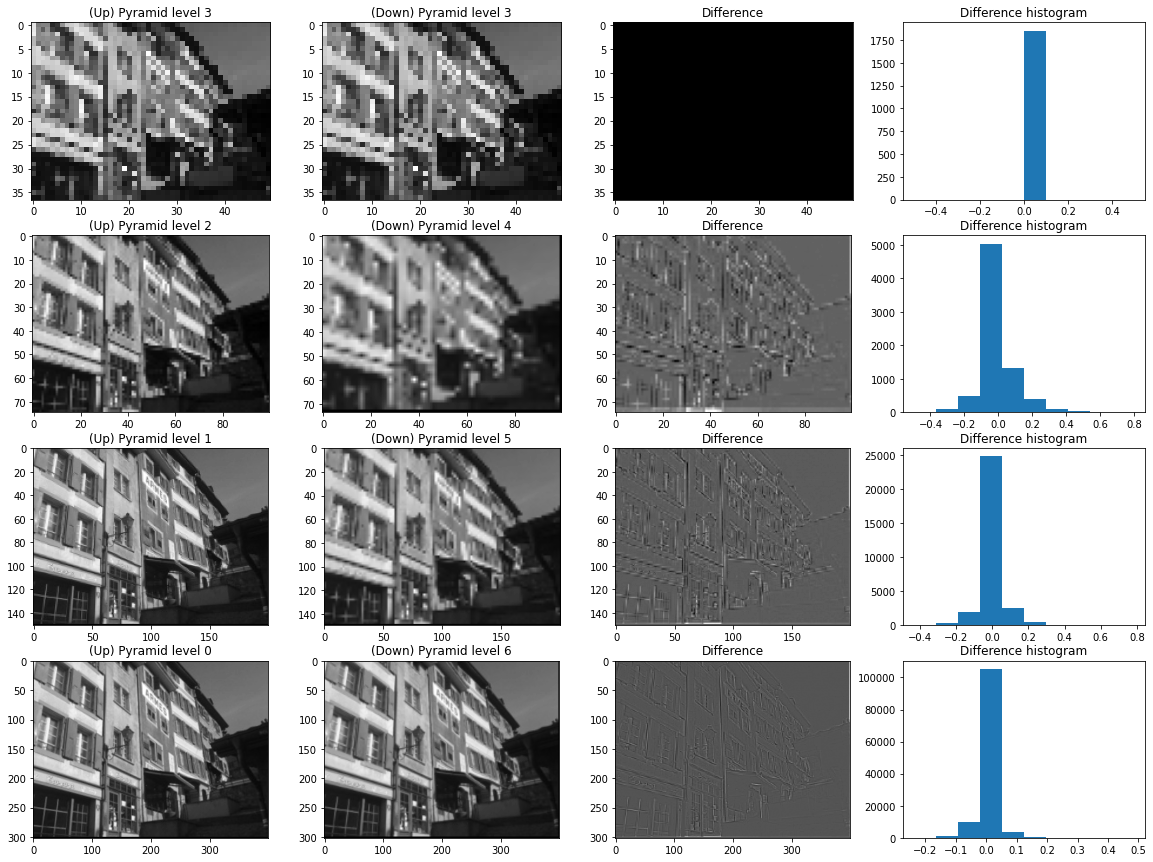

In [34]:
def scale_image (in_image,  scale, sample_order) :
    # Scales in_image size using "scale" factor. Interpolaton of pixels is done using scimage.map_coordinates.
    # "sample_order" specifies the order of the spline interpolation function used.
    height_out, width_out = in_image.shape
    height_out = np.int(height_out * scale)
    width_out = np.int(width_out * scale)

    out_image = np.zeros((height_out, width_out))

    gy, gx = np.meshgrid(np.arange(height_out), np.arange(width_out))
    fx = gx/scale
    fy = gy/scale
    values = scimage.map_coordinates( in_image, [fy, fx], order = sample_order)
    out_image[gy, gx] = values
    
    return(out_image)
#------------------display-----------------------------------------

# Load an color image in grayscale
img = io.imread('//content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data/Armes 1.png')
img = rgb2gray(img)
num_levels = 4
factor = 2.0

# Create image (up) pyramid by downscaling the image by factor
# The pyramid is stored as list:[I_0, I_1, ...., I_n] -- large to small sized.
up_pyramid = []
up_pyramid.append(img)
for i in range (1, num_levels) :
    up_pyramid.append(scale_image (up_pyramid[-1], scale = 1/factor, sample_order = 1)) 

# Create the down pyramid by upscaling from the top of the pyramid
# The pyramid is stored as list:[J_n, J_(n-1), ...., J_0] -- small to large sized.
down_pyramid = []
down_pyramid.append(up_pyramid[-1])
for i in range (1, num_levels) :
    down_pyramid.append(scale_image (up_pyramid[num_levels-i], scale = factor, sample_order = 1)) 

print('\n# Levels of (up) pyramid=', len(up_pyramid), '\n# Levels of (down) pyramid=',len(down_pyramid), '\n# Levels of pyramid=',num_levels)

#------------------display-----------------------------------------

fig, axs = plt.subplots(nrows=num_levels, ncols=4)

fig.set_size_inches (20, 15)

for i in range (num_levels) :
    axs[i, 0].imshow(up_pyramid[-(i+1)], 'gray')
    axs[i, 0].set_title('(Up) Pyramid level {}'.format(num_levels-i-1))

for i in range (num_levels) :
    axs[i, 1].imshow(down_pyramid[i], 'gray')
    axs[i, 1].set_title('(Down) Pyramid level {}'.format(i+num_levels-1))


for i in range (num_levels) :
    # compute error between the reconstructed images at each level from pervious levels
    reconstruction_error = padded_add (up_pyramid[-(i+1)], -down_pyramid[i])
    axs[i, 2].imshow(reconstruction_error, 'gray')
    axs[i, 3].hist(reconstruction_error.reshape(-1))
    axs[i, 2].set_title('Difference')
    axs[i, 3].set_title('Difference histogram')

# Homework 1: Order of interpolation

Try changing the order of interpolation used during sampling in the above code and describe the change in the error of the reconstructed images.

# Difference image pyramid representation

* The difference image pyramid, $\{D_0, D_1, \dots, D_n\}$, has its top-level image same as the top-level representation of the original image pyramid, i.e., $D_n = J_n = I_n$. The rest of the pyramid is the difference (error) images we have seen earlier.

* Thus, the difference-pyramid images are as follows:

\begin{eqnarray}
D_n & =  & I_n \\
D_{n-1} & =  & I_{n-1} - (I_{n}\uparrow^2) \\
\vdots & & \vdots \\
D_ 0& =  & I_{0} - (I_{1}\uparrow^2)
\end{eqnarray}

* The original image can be reconstructed using this difference-image pyramid as follows.

\begin{eqnarray}
\hat{I}_n & =  & D_n \\
\hat{I}_{n-1} & =  & D_{n-1} + (\hat{I}_{n}\uparrow^2) \\
\vdots & & \vdots \\
\hat{I}_0& =  & D_{0} + (\hat{I}_{1}\uparrow^2)
\end{eqnarray}


## Code: Difference Pyramid and reconstructing the image

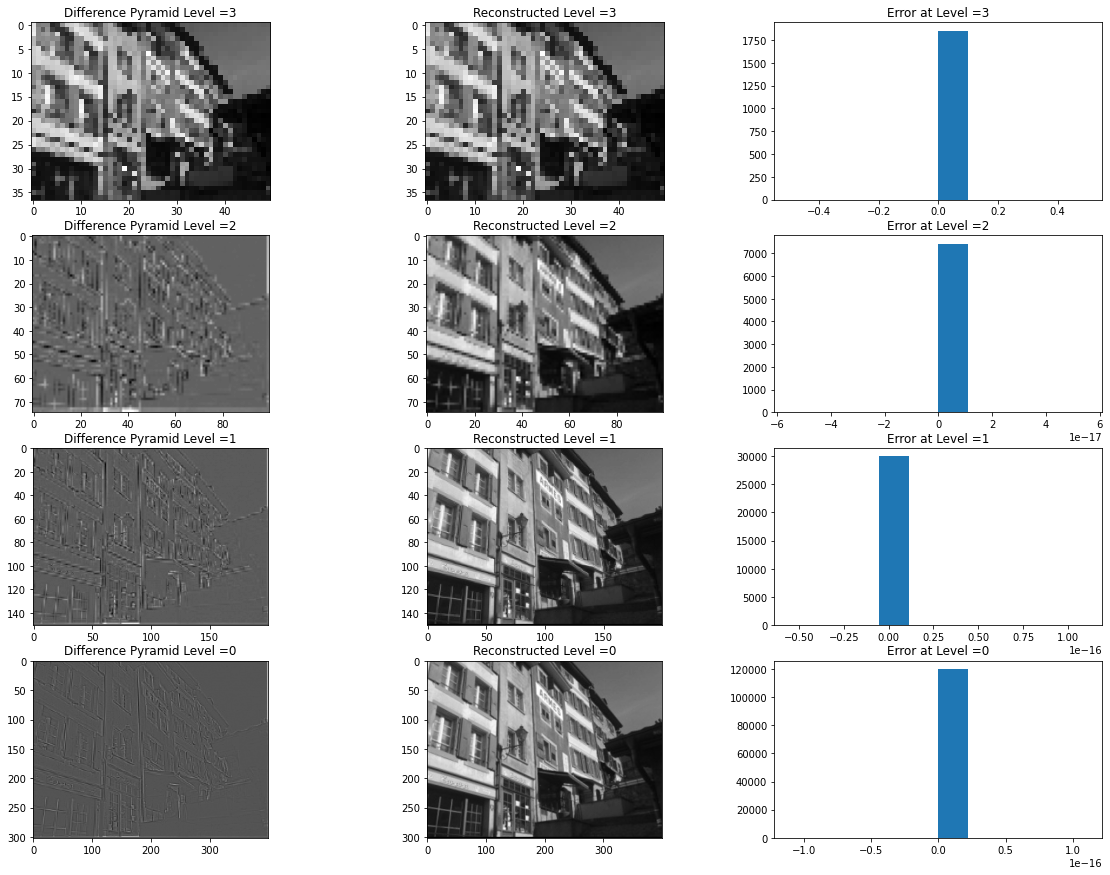

In [ ]:
# The Difference Pyramid is composed of the difference between the images at the 
# corresponding levels of the up- and down- pyramid, except for the top-most level, 
# which is the same as the top-most of the up-pyramid.

difference_pyramid = []
difference_pyramid.append(up_pyramid[-1])
# The pyramid is stored as list:[D_n, D_(n-1), ...., D_0] -- small to large sized.
for i in range (1, num_levels) :
    # compute error between the reconstructed images at each level from pervious levels
    diff_im = padded_add (up_pyramid[-(i+1)], -down_pyramid[i])
    difference_pyramid.append(diff_im)

# Reconstruct the image up-pyramid
# The reconstructed image up-pyramid is stored as list:[I_hat_n, I_hat_(n-1), ...., I_hat_0] -- small to large sized.
I_hat_pyramid = []
I_hat_pyramid.append(difference_pyramid[0])
for i in range (1, num_levels) :
    up_scaled_im = scale_image(I_hat_pyramid[i-1], scale = factor, sample_order = 1)
    reconstructed_image = padded_add (up_scaled_im, difference_pyramid[i])
    I_hat_pyramid.append(reconstructed_image)

#------------------display-----------------------------------------

fig, axs = plt.subplots( nrows=num_levels, ncols=3) #, sharex=True, sharey=True)
fig.set_size_inches (20, 15)
for i in range (num_levels) :
    axs[i, 0].imshow(difference_pyramid[i], 'gray')
    axs[i, 0].set_title('Difference Pyramid Level ={}'.format(num_levels-i-1))
    
    axs[i, 1].imshow(I_hat_pyramid[i], 'gray')
    axs[i, 1].set_title('Reconstructed Level ={}'.format(num_levels-i-1))

    axs[i, 2].hist((up_pyramid[-(i+1)] - I_hat_pyramid[i]).reshape(-1))
    axs[i, 2].set_title('Error at Level ={}'.format(num_levels-i-1))



# Homework 2: Difference Pyramid

Compute the Difference-Pyramid for an image of your choice with number of levels 4 and 8. Comment on how you can use the pyramid to compress an image. Submit on camvas.

## Code: create_difference_pyramid function

In [ ]:
def create_difference_pyramid (up_pyramid, down_pyramid) :
    if (len(up_pyramid) != len(down_pyramid)) :
        print('Error -- the up and down pyramids are of different heights')
        return 0
    
    nlevels = len(up_pyramid)
    difference_pyramid = []
    difference_pyramid.append(up_pyramid[-1])
    # The pyramid is stored as list:[D_n, D_(n-1), ...., D_0] -- small to large sized.
    for i in range (1, nlevels) :
        # compute error between the reconstructed images at each level from pervious levels
        diff_im = padded_add (up_pyramid[-(i+1)], -down_pyramid[i])
        difference_pyramid.append(diff_im)
    return (difference_pyramid)


# Upsampling using convolutions


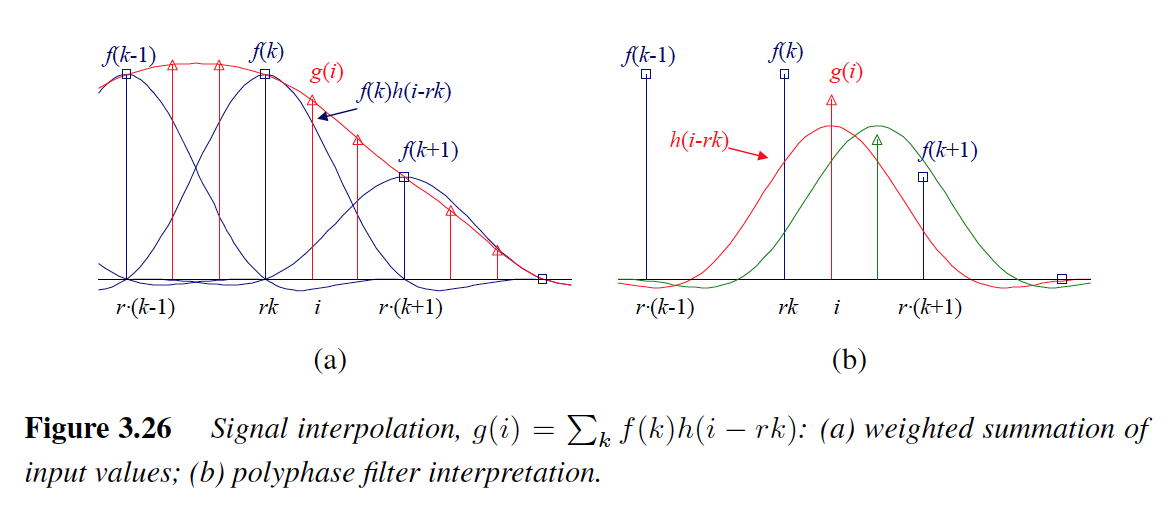

* We can implement the interpolation (upsampling) as a convolution function.

* The above figure is an illustration. Imagine the kernel function $h()$ placed at each sample of the $f()$ function, scaled by the corresponding value of the function. The output is the sum of all these functions.

* In 2D, this function will be

\begin{equation}
g(i, j) = \sum_{k, l} f(k, l) h(i - rk, j - rl)
\end{equation}

* This equation is similar to the convolution equation, except for the multiplication of the $k$ and $l$ indices using $r$.

* For upsampling by a factor of 2, this equation is the following. Note we are considering every other sample of the $h$ function.

\begin{equation}
g(i, j) = \sum_{k, l} f(k, l) h(i - 2k, j - 2l)
\end{equation}

* The above is equivalent to the following

\begin{equation}
g(i, j) = \sum_{k, l} f'(k, l) h(i - k, j - l)
\end{equation}

> where $f'(k, l)$ is constructed out of $f(k, l)$ by inserting zeros between adjacent samples.


* Commonly used interpolating kernels are separable, i.e. the 2D version of the kernel is a product of the 1D versions, just the Gaussian filter $g(x, y) = g(x) g(y)$

* For instance, the 2D Box-3 function 
\begin{equation}
h  = \frac{1}{9} \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1\\ 1 & 1 & 1 \end{bmatrix}
\end{equation}

> is a product of 1D Box-3 filters as follows
\begin{equation}
h  = \left ( \frac{1}{3} \begin{bmatrix} 1  \\ 1 \\ 1  \end{bmatrix} \right )
     \left ( \frac{1}{3} \begin{bmatrix} 1  & 1 & 1  \end{bmatrix} \right )
\end{equation}

> where the 1D Box-3 filter is given by $ \frac{1}{3} \begin{bmatrix} 1  & 1 & 1  \end{bmatrix} $

* Other choices of the interpolating filter are below.

* Nice illustration of the different interpolations in 2D are in https://en.wikipedia.org/wiki/Bilinear_interpolation






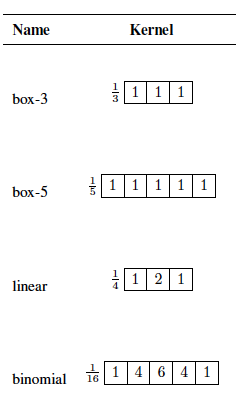

# Code: Study of box, linear, binomial, Gaussian filters

In [ ]:
import scipy.signal

box_2 = np.array([[1, 1]])
linear = scipy.signal.convolve (box_2, box_2)
binomial = scipy.signal.convolve (linear, linear)
print('linear fiter {} is convolution of box-2 filter {} with itself'.format(linear, box_2))

print('The 2D version is the bilinear fiter \n{}'.format(np.transpose(linear)@linear))

print('binomial fiter {} is convolution of linear filter {} with itself'.format(binomial, linear))

gaussian = scipy.signal.gaussian(5, 1)
print('Gaussian filter (sigma = 1) is similar to binomial filter', gaussian/gaussian[0])


linear fiter [[1 2 1]] is convolution of box-2 filter [[1 1]] with itself
The 2D version is the bilinear fiter 
[[1 2 1]
 [2 4 2]
 [1 2 1]]
binomial fiter [[1 4 6 4 1]] is convolution of linear filter [[1 2 1]] with itself
Gaussian filter (sigma = 1) is similar to binomial filter [1.   4.48 7.39 4.48 1.  ]


## Code: up_sample function

In [ ]:
#----------up sampling using convolution--------------------------------
def up_sample (a, kernel) :
    # up samples an array into double the size using convolution with kernel k
    m,n = a.shape
    a_prime = np.zeros((2*m,2*n),dtype=a.dtype)
    a_prime[::2,::2] = a # the array a_prime is now a zero padded version of a 
    out = scipy.signal.convolve2d(a_prime, kernel, mode = 'same')
    return(out, a_prime)

## Code: (down) pyramid using convolutions

1D linear interpolator [[0.5 1.  0.5]]
2D bi-linear interpolator
 [[0.25 0.5  0.25]
 [0.5  1.   0.5 ]
 [0.25 0.5  0.25]]


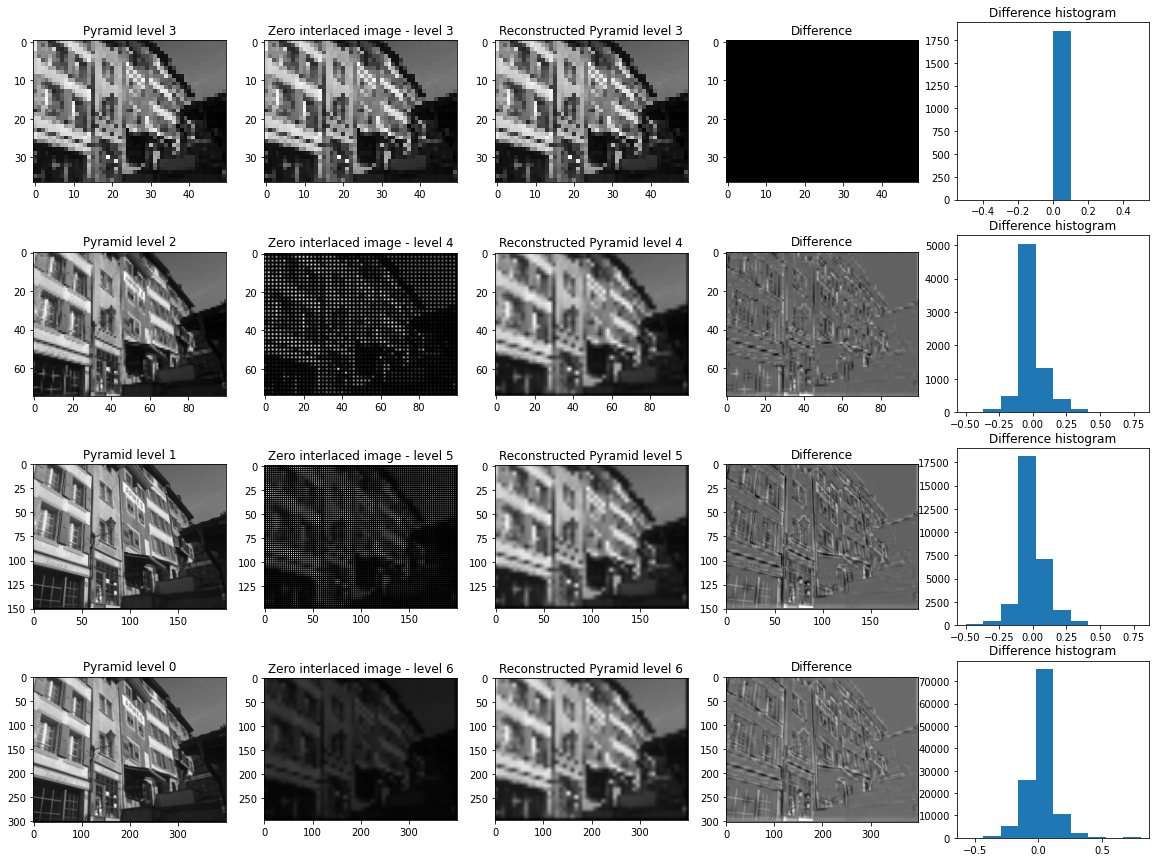

In [ ]:
import scipy.signal

#--------------------------------------------------------------------------
factor = 2;  # upsampling ratio
h   = scipy.signal.convolve2d(np.ones((1, factor)),np.ones((1, factor)))/factor;  # 1D linear interpolator (triangle, plot it and see).
hBL = h.transpose()*h;      # 2D bi-linear interpolator.

print('1D linear interpolator', h)
print('2D bi-linear interpolator\n', hBL)

# Create the (down) pyramid by upscaling from the image from the previous level of (up) pyramid
down_pyramid = []
f_prime = [] # stores the zero padded array -- used just for visualization
down_pyramid.append(up_pyramid[-1])
f_prime.append(up_pyramid[-1])

for i in range (1, num_levels) :
    temp_a, temp_b = up_sample(down_pyramid[-1], hBL)
    down_pyramid.append(temp_a) 
    f_prime.append(temp_b)

#------------------display-----------------------------------------

fig, axs = plt.subplots(nrows=4, ncols=5)

fig.set_size_inches (20, 15)

for i in range (num_levels) :
    axs[i, 0].imshow(up_pyramid[-(i+1)], 'gray')
    axs[i, 0].set_title('Pyramid level {}'.format(num_levels-i-1))

for i in range (num_levels) :
    axs[i, 1].imshow(f_prime[i], 'gray')
    axs[i, 1].set_title('Zero interlaced image - level {}'.format(i+num_levels-1))


for i in range (num_levels) :
    axs[i, 2].imshow(down_pyramid[i], 'gray')
    axs[i, 2].set_title('Reconstructed Pyramid level {}'.format(i+num_levels-1))


for i in range (num_levels) :
    reconstruction_error = padded_add(up_pyramid[-(i+1)], -down_pyramid[i])
    axs[i, 3].imshow(reconstruction_error, 'gray')
    axs[i, 3].set_title('Difference')
    axs[i, 4].hist(reconstruction_error.reshape(-1))
    axs[i, 4].set_title('Difference histogram')


## Code: create_down_pyramid function

In [ ]:
# Codified the down pyramid construction as a function
def create_down_pyramid (pyramid, kernel) :
    # Create the (down) pyramid by upscaling from the image from the previous level of (up) pyramid using kernel
    nlevels = len(pyramid)
    down_pyramid = []
    down_pyramid.append(pyramid[-1])
    for i in range (1, nlevels) :
        temp_a, _ = up_sample(pyramid[-(i)], kernel)
        down_pyramid.append(temp_a) 
    return(down_pyramid)



# Downsampling using convolutions

* The current strategy of reducing the size essentially picks every other pixel to reduce the image size. This type of simple reduction in size introduces an effect called *aliasing*. For an illustration of the aliasing effect, note the ragged nature of the building edges.

* A better strategy is to smooth the image (or low-pass filter it) and select a subsample.

* Convolve with $h()$ and then sample every $r$-th pixel

\begin{equation}
g(i, j) = \sum_{k, l} f(k, l) h(ri - k, kj - l)
\end{equation}

* One typical filter used is the Gaussian filter, thus creating the **Gaussian Pyramid**.

* Approximations versions of the Gaussian filters are also in use.

## Code: create_up_pyramid function

In [36]:
def create_up_pyramid (image, kernel, nlevels) :
    # Create image (up) pyramid by downscaling the image by factor using a 2D kernel k
    pyramid = []
    pyramid.append(image)
    for i in range (1, nlevels) :
        gaussian_smoothed = scipy.signal.convolve2d(pyramid[-1], kernel, mode = 'same')
        pyramid.append(gaussian_smoothed[::2,::2])
    
    return(pyramid)

## Code: (up) pyramid using smoothing convolutions

Binomial kernel of Burt and Adelson (approximately Gaussian)
 [[0.   0.02 0.02 0.02 0.  ]
 [0.02 0.06 0.09 0.06 0.02]
 [0.02 0.09 0.14 0.09 0.02]
 [0.02 0.06 0.09 0.06 0.02]
 [0.   0.02 0.02 0.02 0.  ]] 1.0
Burt and Adelson Binomial interpolator
 [[0.02 0.06 0.09 0.06 0.02]
 [0.06 0.25 0.38 0.25 0.06]
 [0.09 0.38 0.56 0.38 0.09]
 [0.06 0.25 0.38 0.25 0.06]
 [0.02 0.06 0.09 0.06 0.02]] 4.0


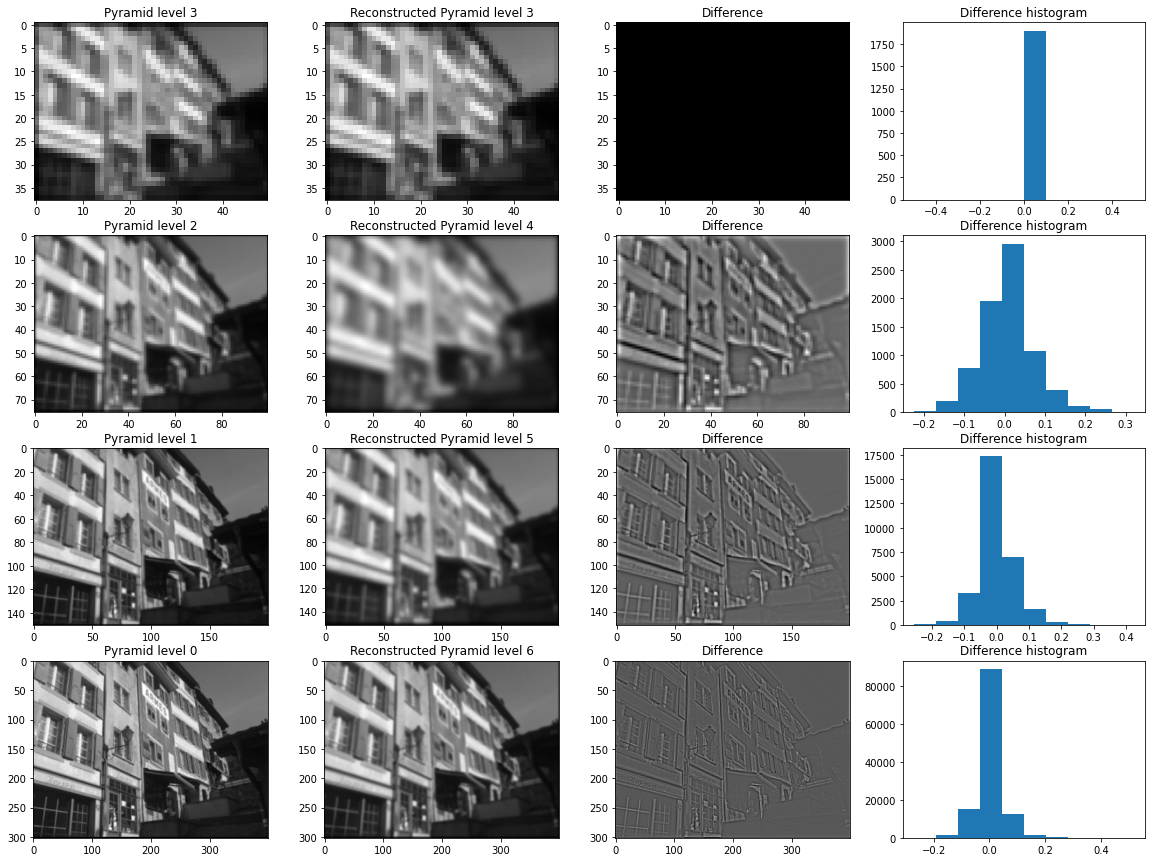

In [37]:
import scipy.signal

# Create the downsampling kernel
g = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]])/2 
# Binomial, approximately Gaussian shaped. 
# This is an option popularized by Burt and Adelson, See http://persci.mit.edu/pub_pdfs/pyramid83.pdf
g_2D = g.transpose()*g;      # 2D Gaussian
print('Binomial kernel of Burt and Adelson (approximately Gaussian)\n', g_2D, np.sum(g_2D))
#--------------------------------------------------------------------------

up_Gaussian_pyramid = create_up_pyramid (img, g_2D, num_levels)

#--------------------------------------------------------------------------
# Create the down pyramid by upscaling from the top of the pyramid
h = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]]) # Binomial filter used by  Burt and Adelson
hBL = h.transpose()*h; 
print('Burt and Adelson Binomial interpolator\n', hBL, np.sum(hBL))
#--------------------------------------------------------------------------
down_Gaussian_pyramid = create_down_pyramid (up_Gaussian_pyramid, hBL)

#------------------display-----------------------------------------

fig, axs = plt.subplots(nrows=num_levels, ncols=4)

fig.set_size_inches (20, 15)

for i in range (num_levels) :
    axs[i, 0].imshow(up_Gaussian_pyramid[-(i+1)], 'gray')
    axs[i, 0].set_title('Pyramid level {}'.format(num_levels-i-1))

for i in range (num_levels) :
    axs[i, 1].imshow(down_Gaussian_pyramid[i], 'gray')
    axs[i, 1].set_title('Reconstructed Pyramid level {}'.format(i+num_levels-1))

for i in range (num_levels) :
    # compute error between the reconstructed images at each level from pervious levels
    reconstruction_error = padded_add (up_Gaussian_pyramid[-(i+1)], -down_Gaussian_pyramid[i])
    axs[i, 2].imshow(reconstruction_error, 'gray')
    axs[i, 2].set_title('Difference')
    axs[i, 3].hist(reconstruction_error.reshape(-1))
    axs[i, 3].set_title('Difference histogram')




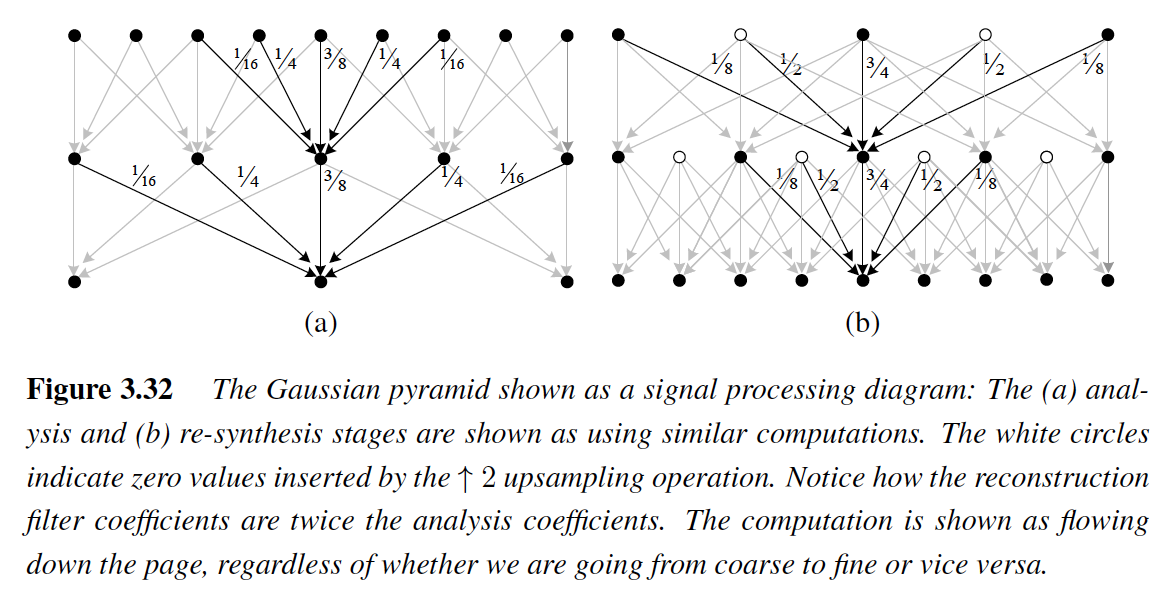

# Laplacian pyramid

* The difference pyramid we get when using the Gaussian pyramid is called the Laplacian pyramid, which Burt and Adelson popularized. See http://persci.mit.edu/pub_pdfs/pyramid83.pdf

* For a Gaussian pyramid, the "error" or "difference" at each level is between two Gaussian smoothed images with $\sigma$'s close to each other. 

* In essence, the "difference" image is the Difference of Gaussian filtered image, which, as we have seen, looks very much like a Laplacian of Gaussian filtered image.

* Hence, we refer to the "difference" image pyramid as the "Laplacian" pyramid.


## Code: Laplacian pyramid

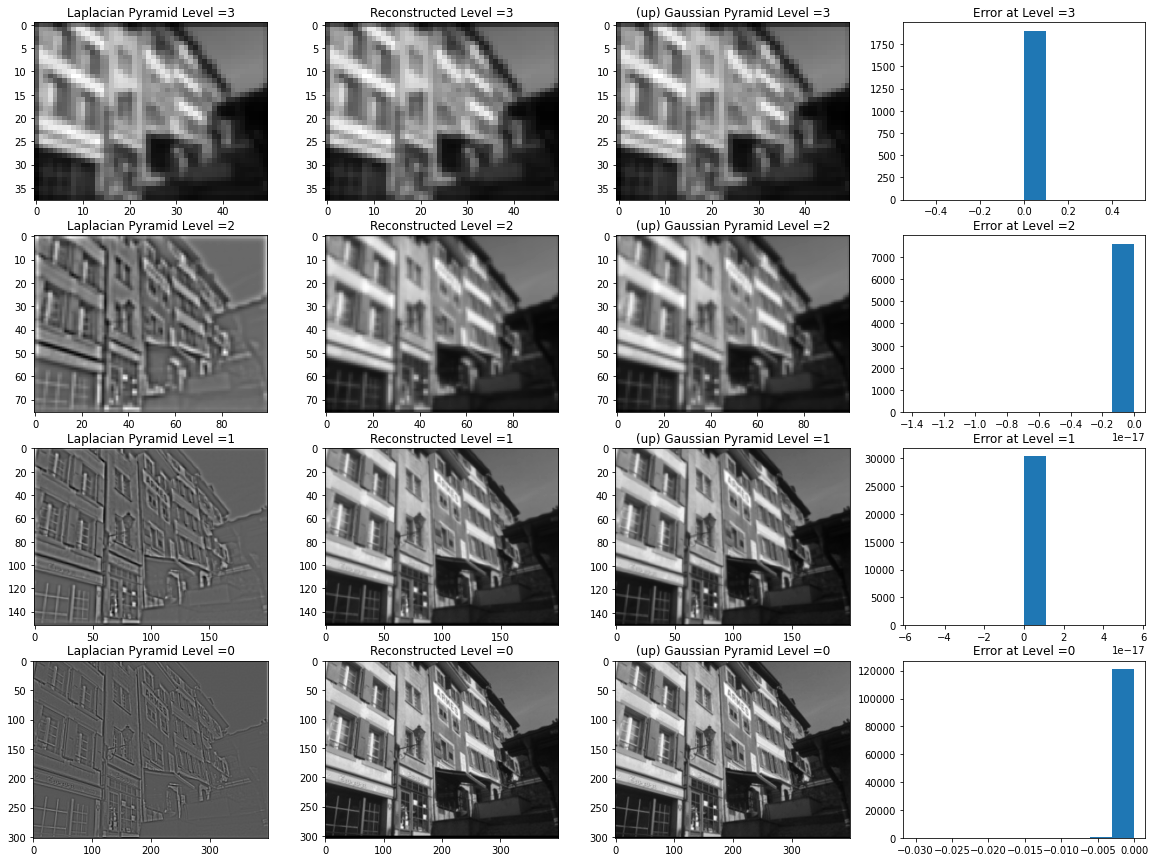

In [ ]:
# Create the down pyramid by upscaling from the top of the pyramid
num_levels = 4
Laplacian_pyramid = create_difference_pyramid (up_Gaussian_pyramid, down_Gaussian_pyramid)

# Reconstruct the image pyramid
# The pyramid is stored as list:[I_hat_n, I_hat_(n-1), ...., I_hat_0] -- small to large sized.
I_hat_pyramid = []
I_hat_pyramid.append(Laplacian_pyramid[0])
for i in range (1, num_levels) :
    up_scaled_im, _ = up_sample(I_hat_pyramid[-1], kernel = hBL)
    reconstructed_image = padded_add (up_scaled_im, Laplacian_pyramid[i])
    I_hat_pyramid.append(reconstructed_image)

#------------------display-----------------------------------------

fig, axs = plt.subplots( nrows=num_levels, ncols=4) #, sharex=True, sharey=True)
fig.set_size_inches (20, 15)
for i in range (num_levels) :
    axs[i, 0].imshow(Laplacian_pyramid[i], 'gray')
    axs[i, 0].set_title('Laplacian Pyramid Level ={}'.format(num_levels-i-1))
    
    axs[i, 1].imshow(I_hat_pyramid[i], 'gray')
    axs[i, 1].set_title('Reconstructed Level ={}'.format(num_levels-i-1))

    axs[i, 2].imshow(up_Gaussian_pyramid[-(i+1)], 'gray')
    axs[i, 2].set_title('(up) Gaussian Pyramid Level ={}'.format(num_levels-i-1))


    axs[i, 3].hist(padded_add(up_Gaussian_pyramid[-(i+1)], - I_hat_pyramid[i]).reshape(-1))
    #axs[i, 3].imshow(padded_add(up_Gaussian_pyramid[-(i+1)], - I_hat_pyramid[i]))
    axs[i, 3].set_title('Error at Level ={}'.format(num_levels-i-1))



## Code: create_Laplacian_pyramid function

    

In [ ]:
def create_Laplacian_pyramid (image, nlevels) :
    
    # Create the downsampling kernel
    g = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]])/2 
    # Burt and Adelson Binomial kernel, approximately Gaussian shaped. 
    g_2D = g.transpose()*g;      # 2D Gaussian
    #--------------------------------------------------------------------------
    up_Gaussian_pyramid = create_up_pyramid (image, g_2D, nlevels)
    #--------------------------------------------------------------------------
    # Create the down pyramid by upscaling from the top of the pyramid
    h = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]]) # Binomial filter used by  Burt and Adelson
    hBL = h.transpose()*h; 
    #--------------------------------------------------------------------------
    down_Gaussian_pyramid = create_down_pyramid (up_Gaussian_pyramid, hBL)
    #--------------------------------------------------------------------------
    Laplacian_pyramid = create_difference_pyramid (up_Gaussian_pyramid, down_Gaussian_pyramid)

    return (Laplacian_pyramid)

In [ ]:
def reconstruct (difference_pyramid) :
    # Reconstruct the image pyramid
    # The pyramid is stored as list:[I_hat_n, I_hat_(n-1), ...., I_hat_0] -- small to large sized.
   # Create the down pyramid by upscaling from the top of the pyramid
    h = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]]) # Binomial filter used by  Burt and Adelson
    hBL = h.transpose()*h; 

    I_hat_pyramid = []
    I_hat_pyramid.append(difference_pyramid[0])
    nlevels = len(difference_pyramid)
    for i in range (1, nlevels) :
        up_scaled_im, _ = up_sample(I_hat_pyramid[-1], kernel = hBL)
        reconstructed_image = padded_add (up_scaled_im, difference_pyramid[i])

        I_hat_pyramid.append(reconstructed_image)
        print(up_scaled_im.shape, difference_pyramid[i].shape, reconstructed_image.shape)

    return(I_hat_pyramid)


(302, 400)
(302, 400)
(6, 8) (6, 8) (6, 8)
(12, 16) (10, 14) (12, 16)
(24, 32) (20, 26) (24, 32)
(48, 64) (38, 50) (48, 64)
(96, 128) (76, 100) (96, 128)
(192, 256) (152, 200) (192, 256)
(384, 512) (302, 400) (384, 512)


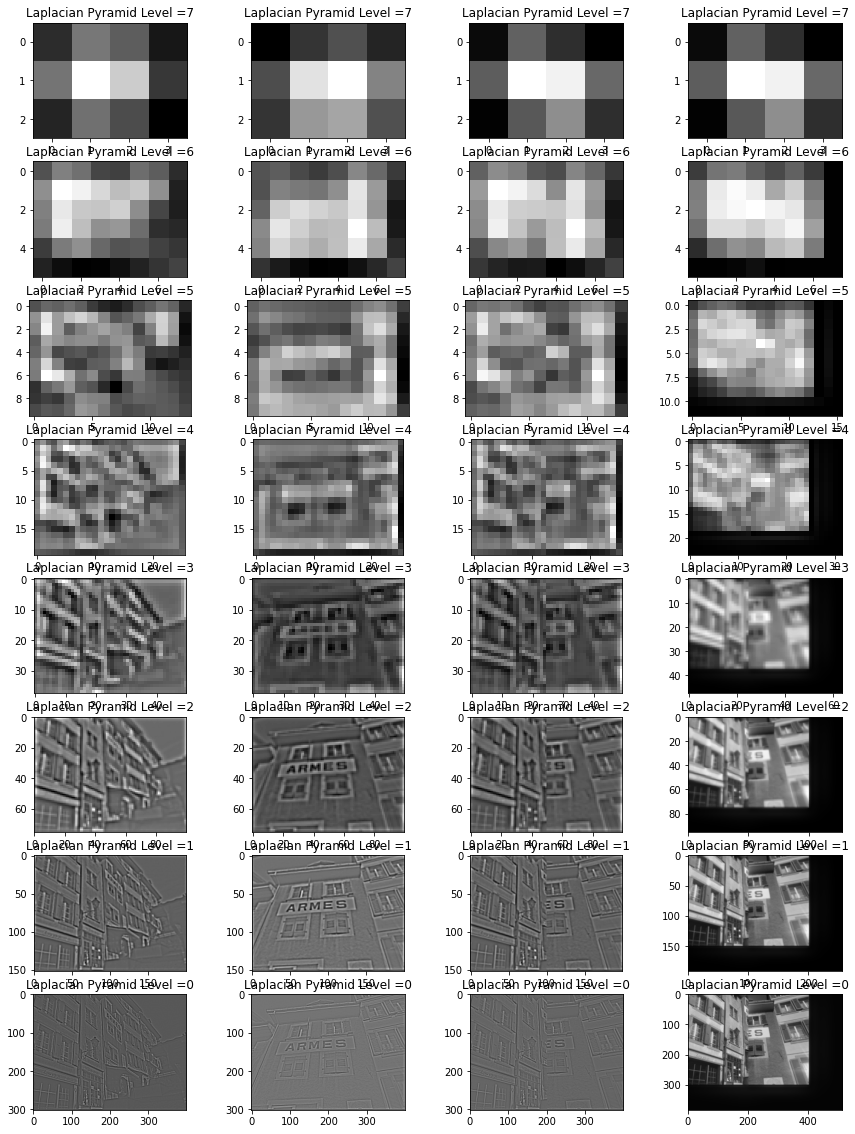

In [ ]:
from skimage.transform import resize

# Load an color image in grayscale
img1 = io.imread('//content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data/Armes 1.png')
img1 = rgb2gray(img1)
print(img1.shape)

img2 = io.imread('//content/drive/MyDrive/Colab Notebooks/CAP 4410 - UG Computer Vision/data/Armes 2.png')
img2 = rgb2gray(img2)
img2 = resize(img2, img1.shape)

print(img2.shape)

num_levels = 8

Laplacian_1 = create_Laplacian_pyramid (img1, nlevels = num_levels)
Laplacian_2 = create_Laplacian_pyramid (img2, nlevels = num_levels)

merged_Laplacian = []

for i in range (num_levels) :
    nR, nC = Laplacian_1[i].shape
    n = np.int(nC/2)
    merged = np.zeros((nR, nC))
    merged[:,0:n] = Laplacian_1[i][:,0:n] 
    merged[:,n:nC] = Laplacian_2[i][:,n:nC]
    merged_Laplacian.append(merged)


blended_image = reconstruct (merged_Laplacian)
#------------------display-----------------------------------------

fig, axs = plt.subplots( nrows=num_levels, ncols=4) #, sharex=True, sharey=True)
fig.set_size_inches (15, 20)
for i in range (num_levels) :
    axs[i, 0].imshow(Laplacian_1[i], 'gray')
    axs[i, 0].set_title('Laplacian Image 1 Level ={}'.format(num_levels-i-1))

    axs[i, 1].imshow(Laplacian_2[i], 'gray')
    axs[i, 1].set_title('Laplacian Image 2 Level ={}'.format(num_levels-i-1))

    axs[i, 2].imshow(merged_Laplacian[i], 'gray')
    axs[i, 2].set_title('Laplacian Blended Level ={}'.format(num_levels-i-1))

    axs[i, 3].imshow(blended_image[i], 'gray')
    axs[i, 3].set_title('Image Blended Level ={}'.format(num_levels-i-1))
    

## Comparison between Laplacian blend with plain cut merge

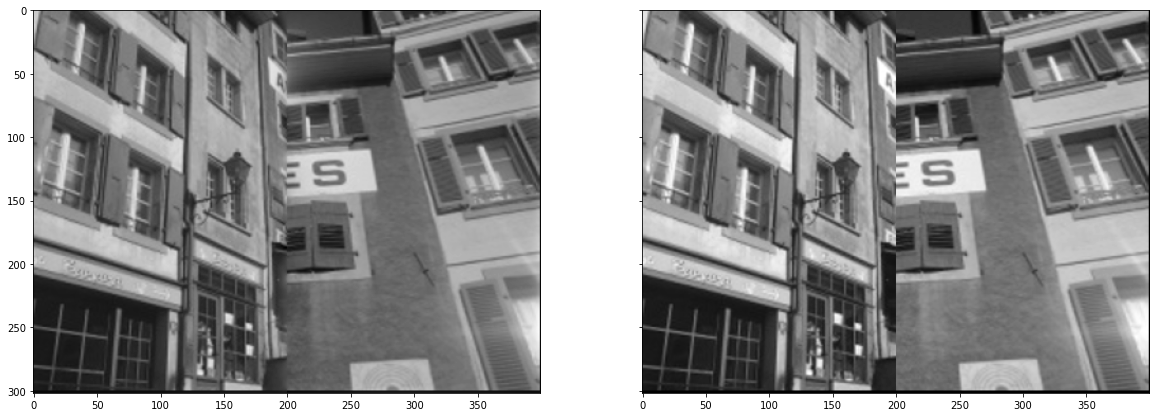

In [ ]:
fig, axs = plt.subplots( nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_size_inches (20, 15)

axs[0].imshow(blended_image[-1], 'gray')

nR, nC = img1.shape
n = np.int(nC/2)
merged = np.zeros((nR, nC))
merged[:,0:n] = img1[:,0:n] 
merged[:,n:nC] = img2[:,n:nC]

axs[1].imshow(merged, 'gray');